# ReAct agent from scratch with Gemini 2.5 and LangGraph

AI applications are evolving from simple chatbots to (semi-)autonomous systems capable of complex reasoning, planning, and interaction with the real world. We call these system agents.

> An AI Agent is a system that uses LLMs to decide the control flow of an application.


Agents are not just theoretical concepts; they are and will be deployed in production across various verticals, tackling increasingly more complex and longer-running tasks. In this blog post, we'll explore how to create a ReAct agent using Google's Gemini 2.5 Pro or Gemini 2.0 Flash and LangGraph from scratch.

## What are ReAct Agents?

ReACT (Reasoning and Acting) Agents are AI systems that combine reasoning capabilities of LLMs with action execution, enabling them to iteratively think through problems, use tools, and act based on observations to achieve the user goals.

The ReAct pattern was first introduced in the [“ReAct: Synergizing Reasoning and Acting in Language Models”](https://arxiv.org/abs/2210.03629) in 2023. It was inspired by how humans plan and solve complex tasks, rather than implementing predefined workflows. ReAct agents rely on the LLM's reasoning capabilities to dynamically adjust their actions based on new information or the results of previous steps.

ReACT Agents have gained traction due to their ability to handle complex tasks by breaking them into manageable reasoning steps and leveraging external tools.


The ReAct agent:

1. Takes a user **query** as input
2. Reasons about the query and decides on an action
3. Executes the chosen action using available tools
4. Observes the result of the action
5. Repeats steps 2-4 until it can provide a final answer

### The First ReAct Agents

These first-generation ReAct agents used a simple but effective prompting technique to generate a chain of "Thought, Action, Observation" steps:

- "Thought" component plans the next action or decide it knows the final answer
- "Action" interacts with external resources (like search engines or calculators).
- "Observation" incorporates the results from the action into the reasoning process.

 Here's a pseudo-code example demonstrating the flow of an early ReAct agent.

```xml
User: Who is Olivia Wilde's boyfriend? What is his current age raised to the 0.23 power?

Thought: I need to find out who Olivia Wilde's boyfriend is and then calculate his age raised to the 0.23 power.
Action: [search("Olivia Wilde boyfriend")]
Observation: Olivia Wilde started dating Harry Styles after ending her years-long engagement to Jason Sudeikis — see their relationship timeline.

Thought: I need to find out Harry Styles' age.
Action: [search("Harry Styles age")]
Observation: 29 years

Thought: I need to calculate 29 raised to the 0.23 power.
Action: [calculator(29^0.23)]
Observation: Answer: 2.169459462491557

Thought: I now know the final answer.
Final Answer: Harry Styles, Olivia Wilde's boyfriend, is 29 years old and his age raised to the 0.23 power is 2.169459462491557.
```

### Current ReAct Agents

Since the introduction of ReAct Agent the capabilities of LLMs has evolved. One of the most important improvements we made is function calling. **Function calling allows us to to connect LLMs to external tools in a structured way, which is more reliable than parsing raw text and reduces the likelihood of errors and hallucinations.**

Here's a pseudo-code example demonstrating the flow of an ReAct agent using function calling

```xml
User: Who is Olivia Wilde's boyfriend? What is his current age raised to the 0.23 power?

Assistant: FunctionCall(name="search", args={"query": "Olivia Wilde boyfriend"})
User: FunctionResponse(result="Olivia Wilde started dating Harry Styles after ending her years-long engagement to Jason Sudeikis — see their relationship timeline.")

Assistant: FunctionCall(name="search", args={"query": "Harry Styles age"})
User: FunctionResponse(result="29 years")

Assistant: FunctionCall(name="calculator", args={"expression": "29^0.23"})
User: FunctionResponse(result="2.169459462491557")

Assistant: Harry Styles, Olivia Wilde's boyfriend, is 29 years old. His age raised to the 0.23 power is 2.169459462491557.
```

### Traditional ReAct Agents vs. Current ReAct Agents (Function Calling)

| **Aspect** | **Traditional ReAct Agents** | **Current ReAct Agents (Function Calling)** |
| --- | --- | --- |
| Actions | Text-based description, parsed by system | Direct function calls in structured format |
| Efficiency | Lower, due to parsing errors | Higher, with reduced parsing overhead |
| Reliability | More prone to errors and hallucinations | More reliable and accurate tool execution |
| LLM Requirement | Works with any LLM | Requires LLMs supporting function calling |
| Implementation | Primarily through careful prompt engineering | Often facilitated by SDKs and frameworks like LangGraph |

# How to create a ReAct agent from scratch with LangGraph

We know have base understanding on how ReAct agents work. Now, let’s build our own from scratch. We are going to use LangGraph and Gemini 2.5 Pro. LangGraph is framework for building controllable agents. LangGraph comes already with prebuilt ReAct agent [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent), but sometimes you might want more control and customization.
Additionally, It is good to understand the underlying concepts and how to build your own ReAct agent from scratch.

LangGraph models agent as graphs. You define the behavior of agents using three key components:
- `State`: Shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel, which is shared across all nodes.
- `Nodes`: Encodes logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an updated State, e.g. LLM calls, tool calls, etc.
- `Edges`: Determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions.

First, we installed required packages and set our API keys. If you don't have an API Key yet you can get one for free in the [Google AI Studio](https://aistudio.google.com/app/apikey).

In [1]:
%pip install langgraph langchain-google-genai geopy requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

In [ ]:
import os

# Read your API key from the environment variable or set it manually
api_key = os.getenv("GEMINI_API_KEY", "place_your_key_here") # 

We are going to create the most basic ReAct agents, which uses mocked 1 tool to retrieve the weather for a given location. For this we need to store the conversation history as a list of messages in our graph state. We are going to use the [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) helper function to add messages to the state. The `add_messages` function is a [reducer](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) that merges two lists of messages, updating existing messages by ID and ensures the state is "append-only", unless the new message has the same ID as an existing message. For demonstration purposes we also store the number of steps in the state.

Note: Since having a list of messages in the state is so common, there exists a prebuilt state called `MessagesState` which makes it easy to use messages.

In [2]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages # helper function to add messages to the state


class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

Next, we define our weather tool.



In [3]:
from langchain_core.tools import tool
from geopy.geocoders import Nominatim
from pydantic import BaseModel, Field
import requests

geolocator = Nominatim(user_agent="weather-app")

class SearchInput(BaseModel):
    location:str = Field(description="The city and state, e.g., San Francisco")
    date:str = Field(description="the forecasting date for when to get the weather format (yyyy-mm-dd)")

@tool("get_weather_forecast", args_schema=SearchInput, return_direct=True)
def get_weather_forecast(location: str, date: str):
    """Retrieves the weather using Open-Meteo API for a given location (city) and a date (yyyy-mm-dd). Returns a list dictionary with the time and temperature for each hour."""
    location = geolocator.geocode(location)
    if location:
        try:
            response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={location.latitude}&longitude={location.longitude}&hourly=temperature_2m&start_date={date}&end_date={date}")
            data = response.json()
            return {time: temp for time, temp in zip(data["hourly"]["time"], data["hourly"]["temperature_2m"])}
        except Exception as e:
            return {"error": str(e)}
    else:
        return {"error": "Location not found"}

tools = [get_weather_forecast]

Next, we initalize our model and bind the tools to the model.

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Create LLM class
llm = ChatGoogleGenerativeAI(
    model= "gemini-2.5-pro-exp-03-25", # replace with "gemini-2.0-flash"
    temperature=1.0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    google_api_key=api_key,
)

# Bind tools to the model
model = llm.bind_tools([get_weather_forecast])

# Test the model with tools
model.invoke("What is the weather in Beijing on 1st of April 2025?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather_forecast', 'arguments': '{"date": "2025-04-01", "location": "Beijing"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro-exp-03-25', 'safety_ratings': []}, id='run-90cfed77-c07b-4d37-a12e-f063abfd6f79-0', tool_calls=[{'name': 'get_weather_forecast', 'args': {'date': '2025-04-01', 'location': 'Beijing'}, 'id': '5dd592a4-0aa5-4f8f-80a4-1f15baac7241', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 31, 'total_tokens': 162, 'input_token_details': {'cache_read': 0}})

The last step before we can run our agent is to define our nodes and edges. In our examples we have **two nodes and 1 edge**.
- `call_tool` **node** that executes our tool method. LangGraph has a prebuilt node for this called [ToolNode](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/).
- `call_model` **node** that uses the `model_with_tools` to call the model.
- `should_continue` **edge** that decides whether to call the tool or the model.

**The number of nodes and edges is not fixed. You can add as many nodes and edges as you want to your graph.** For example, you could add a node for adding structured output or self-verification/reflection node to check the model output before calling the tool or the model.

In [5]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}

# this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
# system_prompt = SystemMessage(
#     "You are a helpful assistant that use tools to access and retrieve information from a weather API. Today is 2025-04-01. Help the user with their questions. Use the history to answer the question."
# )

# Define our tool node
def call_tool(state: AgentState):
    outputs = []
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # Invoke the model with the system prompt and the messages
    response = model.invoke(state["messages"], config)
    # We return a list, because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
    # default to continue
    return "continue"

Awesome, now we have all the components to build our agent. Let's put them together.

In [6]:
from langgraph.graph import StateGraph, END

# Define a new graph with our state
workflow = StateGraph(AgentState)

# 1. Add our nodes
workflow.add_node("llm", call_model)
workflow.add_node("tools",  call_tool)
# 2. Set the entrypoint as `agent`, this is the first node called
workflow.set_entry_point("llm")
# 3. Add a conditional edge after the `llm` node is called.
workflow.add_conditional_edges(
    # Edge is used after the `llm` node is called.
    "llm",
    # The function that will determine which node is called next.
    should_continue,
    # Mapping for where to go next, keys are strings from the function return, and the values are other nodes.
    # END is a special node marking that the graph is finish.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)
# 4. Add a normal edge after `tools` is called, `llm` node is called next.
workflow.add_edge("tools", "llm")

# Now we can compile and visualize our graph
graph = workflow.compile()

We can visualize our graph using the `draw_mermaid_png` method.

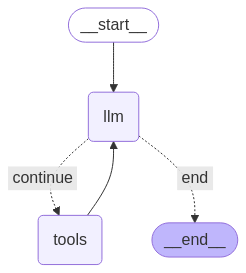

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Awesome, now lets our agent.


In [9]:
# Create our initial message dictionary
inputs = {"messages": [("user", "How is the weather in Beijing on 1st of April 2025?")]}

# call our graph with streaming to see the steps

for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

How is the weather in Beijing on 1st of April 2025?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (fdab2bac-0342-485e-9b10-f531ee3ddc27)
 Call ID: fdab2bac-0342-485e-9b10-f531ee3ddc27
  Args:
    date: 2025-04-01
    location: Beijing
================================= Tool Message =================================
Name: get_weather_forecast

{'2025-04-01T00:00': 9.8, '2025-04-01T01:00': 14.3, '2025-04-01T02:00': 18.3, '2025-04-01T03:00': 19.6, '2025-04-01T04:00': 20.4, '2025-04-01T05:00': 20.8, '2025-04-01T06:00': 20.6, '2025-04-01T07:00': 20.8, '2025-04-01T08:00': 18.3, '2025-04-01T09:00': 18.1, '2025-04-01T10:00': 16.8, '2025-04-01T11:00': 15.0, '2025-04-01T12:00': 13.4, '2025-04-01T13:00': 12.2, '2025-04-01T14:00': 11.4, '2025-04-01T15:00': 10.7, '2025-04-01T16:00': 10.1, '2025-04-01T17:00': 9.5, '2025-04-01T18:00': 8.9, '2025-04-01T

We can now continue with our conversation and for example ask for the weather in another city or let it compare it.

In [10]:
state["messages"].append(("user", "Would it be in Vancouver warmer?"))


for state in graph.stream(state, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

Would it be in Vancouver warmer?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (6d573b4b-ba73-464f-9b65-63ff0f0d0852)
 Call ID: 6d573b4b-ba73-464f-9b65-63ff0f0d0852
  Args:
    date: 2025-04-01
    location: Vancouver
================================= Tool Message =================================
Name: get_weather_forecast

{'2025-04-01T00:00': 11.8, '2025-04-01T01:00': 11.1, '2025-04-01T02:00': 9.3, '2025-04-01T03:00': 8.2, '2025-04-01T04:00': 7.6, '2025-04-01T05:00': 7.2, '2025-04-01T06:00': 6.9, '2025-04-01T07:00': 6.5, '2025-04-01T08:00': 6.4, '2025-04-01T09:00': 6.5, '2025-04-01T10:00': 6.1, '2025-04-01T11:00': 5.7, '2025-04-01T12:00': 5.5, '2025-04-01T13:00': 5.3, '2025-04-01T14:00': 5.0, '2025-04-01T15:00': 5.2, '2025-04-01T16:00': 7.2, '2025-04-01T17:00': 8.6, '2025-04-01T18:00': 9.4, '2025-04-01T19:00': 9.8, '2025-04-01T20:00'